## Preface

If this is your first encounter with clustering, data visualization, or Jupyter notebooks, I recommend going through my notebook named _An Introduction to K-means_ before proceeding. 

In [2]:
import pandas as pd
import altair as alt
from vega_datasets import data
import numpy as np
import math

If you are using the classic Jupyter Notebook (instead of JupyterLab), run the following command to enable the visualizations.

In [3]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Data Visualization?!

Hardcore ML (or ignorant) practitioners may claim that automization and AI will eventually solve everything.

Whether this is true or not, I won't entertain in this notebook. 

However, it remains a current need for humans to be involved in advanced computations on data in order to understand, steer, and correct. 

Enter data visualization.

In the following, you will see a few examples of why visualization is both powerful and potentially deceiving. 

## Understand and adjust computations

In the preceding notebook, visualizations were a key component in understanding how the K-means algorithm worked.

In the first example, we will see how visualization may actually lead to insights that can improve our model.

Let's load some data!

In [2]:
iris = data.iris()
iris.head()

,petalLength,petalWidth,sepalLength,sepalWidth,species
0,1.4,0.2,5.1,3.5,setosa
1,1.4,0.2,4.9,3.0,setosa
2,1.3,0.2,4.7,3.2,setosa
3,1.5,0.2,4.6,3.1,setosa
4,1.4,0.2,5.0,3.6,setosa


The iris dataset is a classic! It is used in many academic contexts for showcasing algorithms and visualizations.

It contains 4 features that describe the width and length of the two different leaf types on an iris flower (see image). 

It also contains a class label describing the type of iris flower. But for now, let's ignore the class label. 

![](../Images/iris_petal_sepal.png)

I have combined the code from the preceeding notebook in a single class that implements the basic version of the K-means algorithm.

In [4]:
class kmeans:
    
    def __init__(self, k, data):
        self.k = k
        self.data = data.copy()
        self.features = data.columns
        self.centroids = self.__random_centroids()
        self.centroid_labels = []
        for i in range(k):
            label = 'c_%d' %i
            self.centroid_labels.append(label)
        
    def __euclidean_distance(self, point, centroid):
        return np.sqrt(np.sum((point - centroid)**2))
    
    def __random_centroids(self):   
        return pd.DataFrame([np.random.random_sample((self.data.shape[1],)) * (self.data.max() - self.data.min()) + self.data.min() for i in range(self.k)], columns=self.features)
    
    def calc_distances(self):
        for i in range(self.k):
            self.data[self.centroid_labels[i]] = self.data[self.features].apply(self.__euclidean_distance, centroid=self.centroids.iloc[i], axis=1)
    
    def assign(self):
        self.data['cluster'] = self.data[self.centroid_labels].idxmin(axis=1)
        
    def update_centroids(self):
        for i in range(self.k):
            temp = self.data.loc[self.data['cluster']==self.centroid_labels[i], self.features].mean()
            if not temp.isnull().values.any():
                self.centroids.iloc[i] = temp
            
    def plot(self, f1, f2):
        if 'cluster' in self.data.columns:
            data_marks = alt.Chart(self.data).mark_circle(size=60, opacity=0.5).encode(
                x=f1,
                y=f2,                
                color=alt.Color('cluster', scale=alt.Scale(scheme='category10'))
            ).interactive()
        else:
            data_marks = alt.Chart(self.data).mark_circle(size=60, opacity=0.5).encode(
                x=f1,
                y=f2
            ).interactive()
            
        centroid_marks = alt.Chart(self.centroids).mark_point(size=100, opacity=1, color='black').encode(
            x=f1,
            y=f2        
        ).interactive()

        return data_marks + centroid_marks

    def fit(self):
        change = True
        old_centroids = None
        while change:
            old_centroids = self.centroids.copy()
            self.calc_distances()
            self.assign()
            self.update_centroids()    
            change = not (old_centroids == self.centroids).values.all()
            
    def result(self):
        return self.data['cluster']

This implementation works for data with multiple dimensions, more than just 2.

It also has a method called _fit_, that computes all the required iterations of the algorithm.

Let's create an instance of the algorithm with the 4 features of our iris dataset and fit the model. 

In [5]:
test1 = kmeans(3, iris[['petalLength', 'petalWidth', 'sepalLength', 'sepalWidth']])
test1.fit()

Plotting different combinations of the features reveals that the resulting clusters do not seperate the data perfectly on all features. 

Try different combinations yourself.

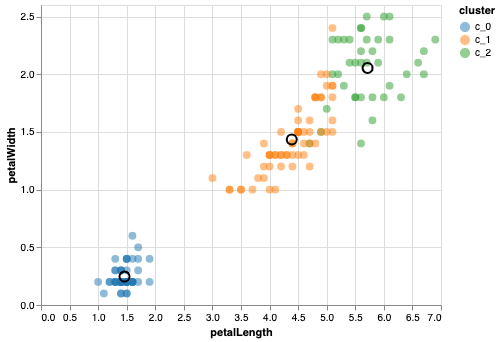

In [11]:
test1.plot('petalLength', 'petalWidth')

And indeed, if we cheat and use the class labels to compute how well we are doing, we are not finding clusters that completely match the actual classes.

Let's count the number of cluster labels that each original class got.

In [8]:
iris['result1'] = test1.result()
iris.groupby(['species', 'result1']).size()

species     result1
setosa      c_0        50
versicolor  c_1        47
            c_2         3
virginica   c_1        14
            c_2        36
dtype: int64

Next, we are mapping the cluster labels to the class labels based on the best match in the result above, which we need to compute the accuracy of our clustering result.

You need to update the map yourself. E.g., if the __setosa__ class has most __c_0__ labels, the map needs to have a mapping that looks like  "c_0: setosa".

In [10]:
map1 = {'c_1': 'versicolor', 
        'c_0': 'setosa', 
        'c_2': 'virginica'}
(iris['species'] == iris['result1'].apply(lambda x : map1[x])).sum() / iris['species'].count()

0.8866666666666667

As some of the features seem to contradict each other in the visualization above, we can instead try and use only a subset of the features.

In [12]:
test2 = kmeans(3, iris[['petalLength', 'petalWidth', 'sepalWidth']])
test2.fit()

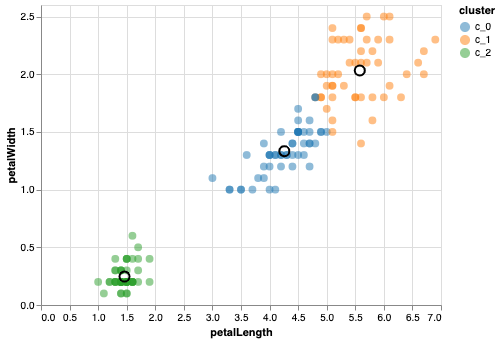

In [13]:
test2.plot('petalLength', 'petalWidth')

Now the result looks slightly better.

Let's check to be sure!

In [14]:
iris['result2'] = test2.result()
iris.groupby(['species', 'result2']).size()

species     result2
setosa      c_2        50
versicolor  c_0        47
            c_1         3
virginica   c_0         4
            c_1        46
dtype: int64

In [15]:
map2 = {'c_0': 'versicolor', 
       'c_2': 'setosa', 
       'c_1': 'virginica'}
(iris['species'] == iris['result2'].apply(lambda x : map2[x])).sum() / iris['species'].count()

0.9533333333333334

And indeed, the clustering result now better represents the actual undelying classes. 

In a real scenario, you would probably use supervised learning instead of clustering when you have the class labels. 

Still, this toy example shows how you can use visualization to get insights that might suggest what you should investigate next.

# Spot patterns or outliers 

Another important use of data visualization is to identify patterns or outliers that certain algorithms may find challenging. 

In this example, we are going to look at 3 different datasets, each with 2 features, __x__ and __y__.

In [3]:
df = pd.read_csv("../Data/random_data.csv")
dataset1 = df[df['dataset'] == 'dataset1'].reset_index(drop=True)
dataset2 = df[df['dataset'] == 'dataset2'].reset_index(drop=True)
dataset3 = df[df['dataset'] == 'dataset3'].reset_index(drop=True)

In [19]:
dataset3.head()

,dataset,x,y
0,dataset3,55.3846,97.1795
1,dataset3,51.5385,96.0256
2,dataset3,46.1538,94.4872
3,dataset3,42.8205,91.4103
4,dataset3,40.7692,88.3333


One of the first things you may do when encountering new datasets is to compute a set of summary stastistics to get an idea of how similar the datasets are.

Statistics which many algorithms also rely on. 

Try the __stats__ function on the 3 datasets.

In [21]:
def stats(df):
    print("Mean x:", df.x.mean()) 
    print("Mean y:", df.y.mean()) 
    print("Std x:", df.x.std()) 
    print("Std y:", df.y.std())
    print("Corr:", df.x.corr(df.y))

In [22]:
stats(dataset1)

Mean x: 54.26609978420493
Mean y: 47.83472062488411
Std x: 16.769824954157368
Std y: 26.939743418883353
Corr: -0.06412835215474486


In [24]:
stats(dataset3)

Mean x: 54.26327323943664
Mean y: 47.832252816901374
Std x: 16.765142039116785
Std y: 26.935403486939123
Corr: -0.06447185270095167


Looks quite similar, eh?

Now try and visualize the 3 datasets!

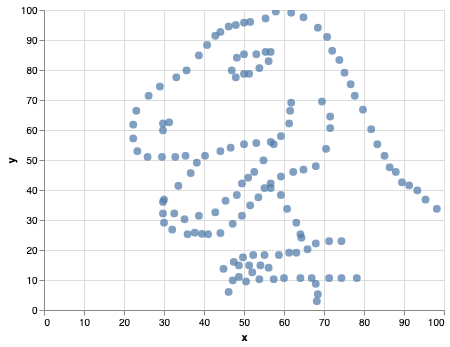

In [27]:
alt.Chart(dataset3).mark_circle(size=60).encode(
    x='x',
    y='y'
).interactive()

Did you spot the difference?

Spotting interesting patterns and outliers can lead to smarter feature engineering or model design! 

# Visualization design is important

While the concept of data visualization is powerful and important, _just_ visualizing your data is not enough.

Data visualizations can also be quite deceiving, depending on which type of visualization is used and for what purpose.   

This example shows how the box-plot actually hides a lot of information that the violin-plot maintains.

![](../Images/BoxViolinSmaller.gif)

## Epilogue

Note, this was just a small excerpt of examples illustrating that data visualization is a powerful tool, but also that data visualization can be deceiving. 

Data visualization is an important skill in data analytics, both for improving analysis results but also for communicating findings.

Thus, learning data visualization will be a useful asset both in your studies and in your professional endeavours. 

Data and gif source: https://www.autodeskresearch.com/publications/samestats